# Matrix Factorization

Having created out baseline results, we can try different methods for determining the predicted review scores. One method is to assume there are latent factors which drive the scores given by users. Matrix factorization is one method of trying to model these latent factors.

Given a set of (user, restaurant, review scores), we can construct a matrix out of these where each row is a user, each column is a restaurant, and the value of each cell is the rating assigned by the user. Let's call this matrix S.

Matrix factorization seeks to reconstruct S by splitting it into two matrices, U & R, such that UR = S. The dimensions of U & R are (# users x latent factors) & (# latent factors x restaurants) respectively. By selecting a higher number of dimensions, we are assuming there are more factors which exist and which we subsequently are trying to represent.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import sklearn.metrics as metrics
from sklearn.model_selection import cross_val_score
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegressionCV
import math
import time
import logging
%matplotlib inline

In [92]:
def graph_rmse_error(train_errors, test_errors):
    # Given an array of training and testing RMSE errors / iteration, graph them.
    axes = plt.figure().gca()
    axes.plot(train_errors, label='Train')
    axes.plot(test_errors, label='Test')
    max_y = max(max(train_errors), max(test_errors))
    axes.set_ylim(0,max_y + max_y/10)
    axes.set_xlim(0,len(train_errors))
    start, end = axes.get_xlim()
    if (len(train_errors) < 20):
        axes.xaxis.set_ticks(range(len(train_errors)))
    else:
        axes.xaxis.set_ticks(range(0, len(train_errors), math.floor(len(train_errors)/20)))
    axes.xaxis.set_major_formatter(ticker.FormatStrFormatter('%0.f'))
    axes.set_xlabel('Iteration')
    axes.set_ylabel('RMSE')
    axes.set_title('RMSE vs Iterations')
    plt.legend(loc="lower right")

In [11]:
# Read data into a sparse matrix where each row is a user and each column is a restaurant.
# Creating a dense matrix caused out of memory issues.
def create_train(filename):
    from scipy.sparse import coo_matrix
    data = pd.read_csv(filename, header=None, names=['user_id', 'restaurant_id', 'score'])
    
    # this allows us to convert user/restaurants to ints quickly.
    data['user_id'] = data['user_id'].astype('category')
    data['restaurant_id'] = data['restaurant_id'].astype('category')
    
    user_to_id = dict([[v,k] for k,v in dict(enumerate(data['user_id'].cat.categories)).items()])
    restaurant_to_id = dict([[v,k] for k,v in dict(enumerate(data['restaurant_id'].cat.categories)).items()])

    # Map user & restaurant ids to ints.
    data['u_index'] = data['user_id'].apply(lambda x: user_to_id[x]).astype('int64')
    data['r_index'] = data['restaurant_id'].apply(lambda x: restaurant_to_id[x]).astype('int64')
    
    # create a sparse matrix of (user_index, restaurant_index, score)
    sparse = coo_matrix((data['score'], (data['u_index'], data['r_index'])))
    return data, sparse, user_to_id, restaurant_to_id

In [59]:
# Read data into a sparse matrix similar to create_train. Use the user_id -> index & restaurant_id -> index
# mappings from training set to ensure we have the same indices.
def create_test(filename, user_id_to_index, restaurant_id_to_index):
    from scipy.sparse import coo_matrix
    data = pd.read_csv(filename, header=None, names=['user_id', 'restaurant_id', 'score'])
    
    # Map rId and uId to same values as in training set.
    data['u_index'] = data['user_id'].apply(lambda x: user_id_to_index[x])
    data['r_index'] = data['restaurant_id'].apply(lambda x: restaurant_id_to_index[x])

    # create a sparse matrix of (userId, restaurantId, score)
    sparse = coo_matrix((data['score'], (data['u_index'], data['r_index'])))
    return data, sparse

In [46]:
def rmse(users_items, user_factors, item_factors):
    # Calculate Root Mean Square Error for matrix.
    user_items_coo = users_items.tocoo()
    e = 0
    for i, j, v in zip(user_items_coo.row, user_items_coo.col, user_items_coo.data):
        e += (v - user_factors[i].dot(item_factors[j]))**2
    return math.sqrt(e/len(user_items_coo.data))

def create_a_b(Y, YtY, u_i, u, regularisation, n_latent_factors):
    # According to section 4 of http://yifanhu.net/PUB/cf.pdf we can build A & b piecemeal by
    # Xu = Inv((Yt*Cu*Y + λI)) * Yt*Cu*p(u)
    # A is (Yt*Cu*Y + λI)
    # b is Yt*Cu*p(u)
    # A can be re-written as = YtY + Yt(Cu − I)Y + λI

    # Init A to be YtY + λI. We'll add Yt(Cu − I)Y below.
    A = YtY + regularisation * np.eye(n_latent_factors)

    # b starts off empty and will be accumulated below.
    b = np.zeros(n_latent_factors)

    for i, score in nonzero_col_values(u_i, u):
        factor = Y[i]
        A += (score - 1) * np.outer(factor, factor)
        b += score * factor
    return A, b

def least_squares(u_i, X, Y, regularization):
    # If we were able to keep a dense matrix in memory, we could simply do
    # A = YtY + regularisation * np.eye(n_latent_factors), 
    # b = np.dot(Y, u_i.T)
    
    # Since we're using a sparse matrix, we have to build each entry individually.
    users, n_latent_factors = X.shape
    YtY = Y.T.dot(Y)

    for user in range(users):
        A, b = create_a_b(Y, YtY, u_i, user, regularization, n_latent_factors)
        X[user] = np.linalg.solve(A, b)
        
def nonzero_col_values(matrix, row):
    # Returns the nonzero column indicies and values for the provided row.
    for index in range(matrix.indptr[row], matrix.indptr[row+1]):
        yield matrix.indices[index], matrix.data[index]

In [78]:
def fit(train_users_items, test_users_items, factors, iterations, regularisation):
    # fit takes the sparse matrix of training data (format is ((user index, restaurant index), review score)),
    # the sparse matrix of test data (just for error computation),
    # the number of latent factors to calculate
    # the number of iterations to execute before stopping,
    # the amount of regularisation to apply.
    #
    # Step 1 is to create initial user & item factor matrices.
    # After doing so, we alternate least squares on the user & item matrices by
    # first updating the user factors (holding item factors constant)
    # and then the item factors (holding the user factors constant)
    # We then calculate the RMSE for the train and test set and store this on each iteration
    # Ultimately we return the final user factors & item factors, as well as the train & test errors
    # for each iteration. 
    u_i = train_users_items.tocsr()
    i_u = train_users_items.T.tocsr()

    users, items = u_i.shape
        
    # Initialize the factor matrices randomly. Since scores go from 0 - 5, we multiply by 5.
    user_factors = np.random.rand(users, factors) #* 2
    item_factors = np.random.rand(items, factors) #* 2
        
    prev_rmse = 0
    train_errors = []
    test_errors = []
    
    for i in range(iterations):
        s = time.time()
        least_squares(u_i, user_factors, item_factors, regularisation)
        least_squares(i_u, item_factors, user_factors, regularisation)
        elapsed = time.time() - s
        train_err = rmse(train_users_items, user_factors, item_factors)
        train_errors.append(train_err)
        test_errors.append(rmse(test_users_items, user_factors, item_factors))
        # Print status every 10 iterations.
        if (i % 10 == 0):
            print("Finished iteration {0} in {1:.3f}".format(i, elapsed))
            if prev_rmse > 0:
                print("Error: {0:.3f}, delta: {1:.3f}".format(train_err, prev_rmse - train_err))
            else:
                print("Error: {0:.3f}".format(train_err))
        prev_rmse = train_err
        
    return user_factors, item_factors, train_errors, test_errors

## Load Ohio Training & Test Datasets

After loading the training dataset, we map the user ids & restaurant ids to row & column indices.
These indices are used for constructing the test dataset.

In [50]:
oh_train, oh_train_sparse, oh_u_to_i, oh_r_to_i = create_train('/Users/asciola/workspace/source/more/OH_NO/OH_train_150.csv/part-00000')
oh_test, oh_test_sparse = create_test('/Users/asciola/workspace/source/more/OH_NO/OH_test_150.csv/part-00000', oh_u_to_i, oh_r_to_i)

## Factorize Test Matrix

Using Alternating Least Squares, we repeatedly factorize and approximate the training matrix.
There are 3 meta-parameters we can play with:
Number of Latent Factors - More factors lead to lower overall error as it represents more of the groupings which exist
Number of Iterations - As we repeatedly apply ALS, we're trying to minimise the error at each run. By holding one of the matrices constant, we can solve the decomposition problem, getting a better result, and then using the better result for one matrix to try and get a better result for the other.
Regularisation - The higher the regularisation, the less we (hopefully) overfit to the training data.

In [88]:
(oh_train_user_factors, oh_train_item_factors,
 oh_train_errors, oh_test_errors) = fit(oh_train_sparse, oh_test_sparse, 500, 10, 0.5)

Finished iteration 0 in 14.572
Error: 2.946


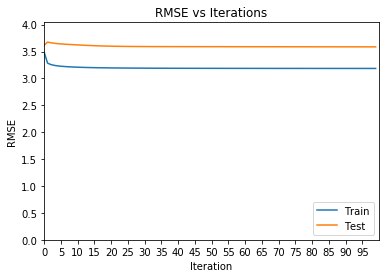

In [93]:
graph_rmse_error(oh_train_errors, oh_test_errors)

In [94]:
(oh_train_user_factors, oh_train_item_factors,
 oh_train_errors, oh_test_errors) = fit(oh_train_sparse, oh_test_sparse, 5, 100, 0.5)

Finished iteration 0 in 0.182
Error: 3.491
Finished iteration 10 in 0.132
Error: 3.208, delta: 0.003
Finished iteration 20 in 0.168
Error: 3.196, delta: 0.001
Finished iteration 30 in 0.150
Error: 3.191, delta: 0.000
Finished iteration 40 in 0.156
Error: 3.188, delta: 0.000
Finished iteration 50 in 0.125
Error: 3.187, delta: 0.000
Finished iteration 60 in 0.137
Error: 3.186, delta: 0.000
Finished iteration 70 in 0.147
Error: 3.185, delta: 0.000
Finished iteration 80 in 0.138
Error: 3.185, delta: 0.000
Finished iteration 90 in 0.131
Error: 3.185, delta: 0.000


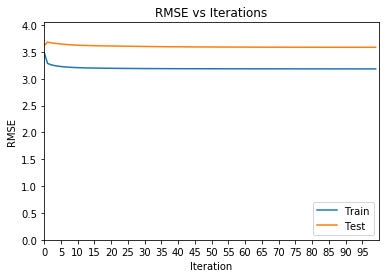

In [95]:
graph_rmse_error(oh_train_errors, oh_test_errors)

## Conclusions

We see that we rapidly approach our best values with only a few iterations. This suggests that there isn't much latent information in the dataset provided.
Looking at larger datasets (not restricted to just OH) shows more iterations and more factors help substantially.